### Constructing fault-tolerant weight-6 Pauli measurements

The surface code is beautifully simple. We only need to measure weight-4 Pauli operators, and this makes (strictly) fault tolerant circuits relatively easy to find. However, some of the codes we've heard about require higher weight checks, so let's explore some weight-6 Pauli measurement circuits.

Our starting point is the circuit proposed by Chamberland, Kubica, Yoder, and Zhu (arXiv:1911.00355) for measuring color code stabilizers (see Figure 3b of their paper). 

This circuit is 1-fault-tolerant in the sense that if any single location fails, we can examine the flag outcomes and find a local (to the check) correction such that there is at most one error remaining on the data qubits. Our first goal is to verify that fact.

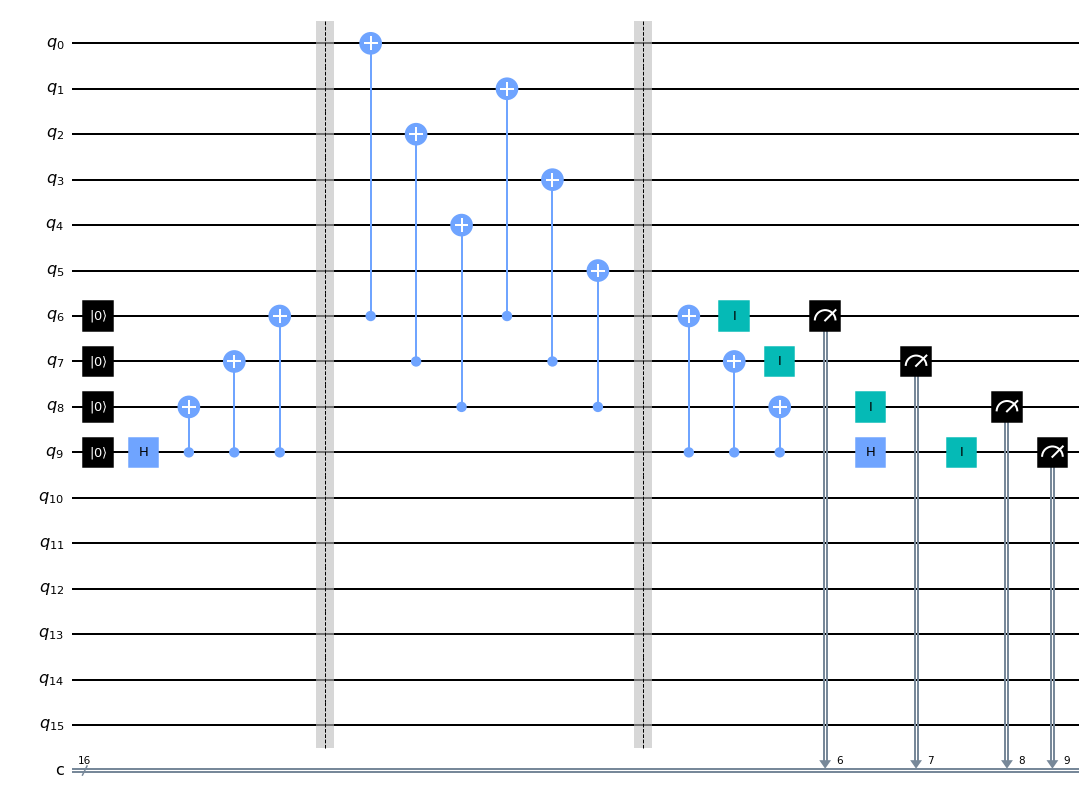

In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(16, 16)  # 6 extra qubits we'll use later
# Prepare aux. system
qc.reset(6)
qc.reset(7)
qc.reset(8)
qc.reset(9)
qc.h(9)
qc.cx(9, 8)
qc.cx(9, 7)
qc.cx(9, 6)
qc.barrier()
# Interact with code block
qc.cx(6, 0)
qc.cx(7, 2)
qc.cx(8, 4)
qc.cx(6, 1)
qc.cx(7, 3)
qc.cx(8, 5)
qc.barrier()
# Measure aux. system
qc.cx(9, 6)
qc.cx(9, 7)
qc.cx(9, 8)
qc.h(9)
qc.id(6)
qc.id(7)
qc.id(8)
qc.id(9)
qc.measure(6, 6)
qc.measure(7, 7)
qc.measure(8, 8)
qc.measure(9, 9)
qc.draw(output='mpl')

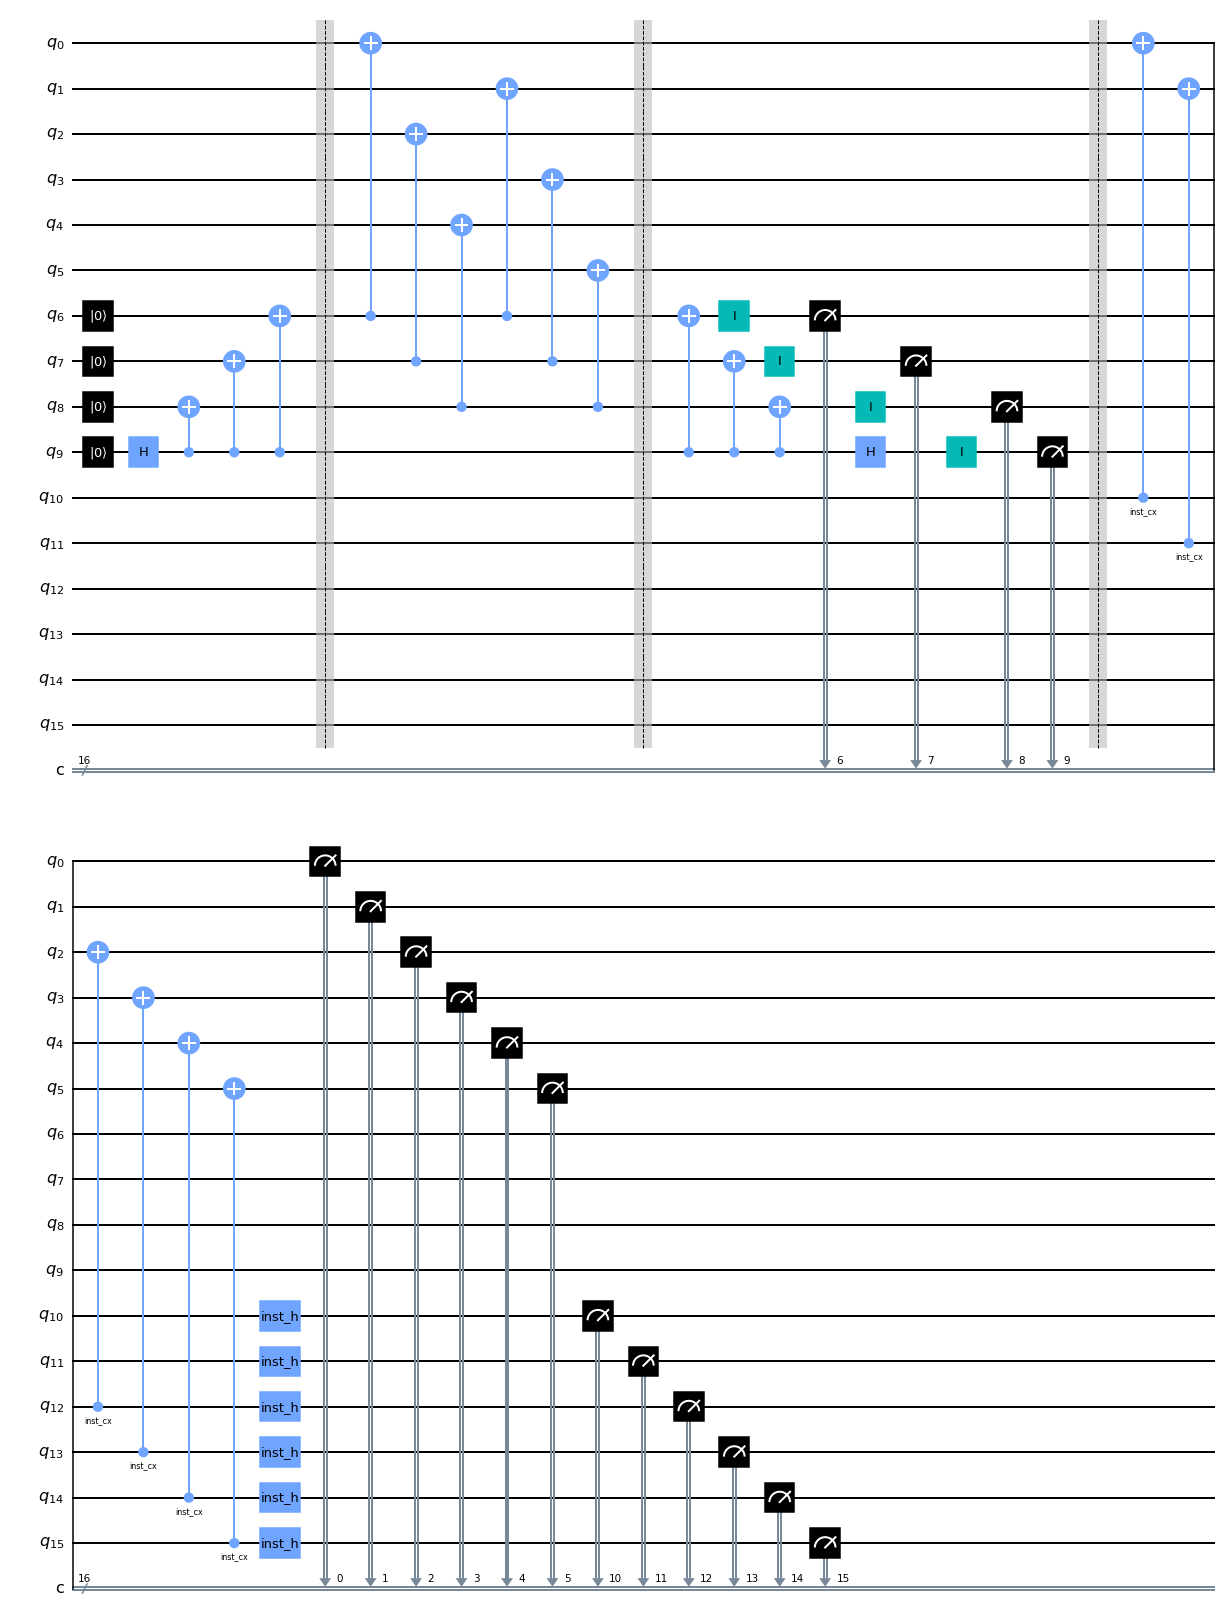

In [2]:
from copy import deepcopy
from qiskit.circuit.library import HGate

qc_1 = deepcopy(qc)
# Instrument the code block to detect bit and phase flips
qc_1.barrier()
for i in range(6):
    qc_1.cx(i + 10, i, label="inst_cx")
    qc_1.append(HGate(label="inst_h"), [qc.qubits[i+10]])
for i in range(6):
    qc_1.measure(i, i)
    qc_1.measure(i + 10, i + 10)
qc_1.draw(output="mpl")

### Pauli noise model definition

In [3]:
from qiskit_qec.noise.paulinoisemodel import PauliNoiseModel

model = PauliNoiseModel()
model.add_operation("cx", {"ix": 1, "iy": 1, "iz": 1,
                        "xi": 1, "xx": 1, "xy": 1, "xz": 1,
                        "yi": 1, "yx": 1, "yy": 1, "yz": 1,
                        "zi": 1, "zx": 1, "zy": 1,
                        "zz": 1})
model.add_operation("reset", {"x": 1})
# model.add_operation("measure", {"x": 1})
model.add_operation("id", {"x": 1})
model.add_operation("h", {"x": 1, "y": 1, "z": 1})

### Enumerate all single-fault paths

In [4]:
from qiskit_qec.analysis.faultenumerator import FaultEnumerator

fe = FaultEnumerator(qc_1, 1, "propagator", model=model, sim_seed=0)
result = list(fe.generate_blocks())[0]
result

[(0, ['reset'], ['x'], [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (1, ['reset'], ['x'], [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 (2, ['reset'], ['x'], [0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 (3, ['reset'], ['x'], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 (4, ['h'], ['x'], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (5, ['h'], ['y'], [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 (6, ['h'], ['z'], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 (7, ['cx'], ['ix'], [0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 (8, ['cx'], ['iy'], [0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]),
 (9, ['cx'], ['iz'], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 (10, ['cx'], ['xi'], [1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 (11, ['cx'], ['xx'], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (12, ['cx'], ['xy'], [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 (13, ['cx'], ['xz'], [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 

In [5]:
count = qc.count_ops()
print(count)
num_paths = count['reset'] + count['id'] + count['h']*3 + count['cx']*15
print(num_paths)

OrderedDict([('cx', 12), ('reset', 4), ('id', 4), ('measure', 4), ('h', 2), ('barrier', 2)])
194


In [6]:
# Apply corrections based on flags ('deflag')
# if f_1 (bit 6), apply X_1
# if f_2 (bit 7), apply X_3
# if f_3 (bit 8), apply X_5
# if f_2 and f_3 (bits 7 and 8), apply X_0
def process_flags(result):
    processed_result = deepcopy(result)
    for record in processed_result:
        flags = record[3][6:9]
        if flags == [1, 0, 0]:
            record[3][1] ^= 1
        if flags == [0, 1, 0]:
            record[3][3] ^= 1
        if flags == [0, 0, 1]:
            record[3][5] ^= 1
        if flags == [0, 1, 1]:
            record[3][0] ^= 1
    return processed_result
processed_result = process_flags(result)

Let's now check that a 1-good measurement circuit does not produce errors of weight greater than 1 on the data.

In [10]:
weights = {}
for record in processed_result:
    datax = record[3][0:6]
    dataz = record[3][10:16]
    if sum(datax) > 3:
        datax = [(x + 1) % 2 for x in datax]
    num_errors = sum([int((x + y) > 0) for x, y in zip(datax, dataz)])
    weights.setdefault(num_errors, set([]))
    weights[num_errors].add((sum(datax), sum(dataz)))
    if num_errors > 1:
        print("FAILED!")
weights

{1: {(0, 1), (1, 0), (1, 1)}, 0: {(0, 0)}}

All good!

### How about pairs of faults?

The circuit is not designed to be strictly fault-tolerant against multiple faults. Instead, in the paper, the flag outcomes are combined with syndrome information to achieve fault-tolerance. This is a great strategy, since the Pauli measurement circuits might become more complicated if they need to detect higher order error propagations.

However, it might also be desirable to have subcircuits that "work" regardless of the specific set of correctable errors of the quantum code. Is it possible that we are lucky and the circuit is 2-fault-tolerant?

In [11]:
fe2 = FaultEnumerator(qc_1, 2, "propagator", model=model, sim_seed=0)
result = []
for x in fe2.generate_blocks():
    result.extend(x)
processed_result = process_flags(result)
processed_result

[(0,
  ['reset', 'reset'],
  ['x', 'x'],
  [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 (1,
  ['reset', 'reset'],
  ['x', 'x'],
  [1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 (2,
  ['reset', 'reset'],
  ['x', 'x'],
  [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 (3,
  ['reset', 'h'],
  ['x', 'x'],
  [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (4,
  ['reset', 'h'],
  ['x', 'y'],
  [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 (5,
  ['reset', 'h'],
  ['x', 'z'],
  [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 (6,
  ['reset', 'cx'],
  ['x', 'ix'],
  [1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 (7,
  ['reset', 'cx'],
  ['x', 'iy'],
  [1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]),
 (8,
  ['reset', 'cx'],
  ['x', 'iz'],
  [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 (9,
  ['reset', 'cx'],
  ['x', 'xi'],
  [0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 (10,
  ['reset', 'cx'],
  ['x', 'xx'],
  [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0

In [12]:
count = qc.count_ops()
def choose2(n):
    return int(n*(n-1)/2)
num_paths = choose2(count['reset']) + choose2(count['id']) + \
    3*3*choose2(count['h']) + 15*15*choose2(count['cx']) + \
    count['reset']*count['id'] + 3*count['reset']*count['h'] + \
    15*count['reset']*count['cx'] + 3*count['id']*count['h'] + \
    15*count['id']*count['cx'] + 3*15*count['h']*count['cx']
print(num_paths)
print(len(result))

17455
17455


In [13]:
bad_records = []
for record in processed_result:
    data = record[3][0:6]  # X errors on the data
    num_errors = sum(data)
    if num_errors > 3:
        num_errors = 6 - num_errors
    if num_errors > 2:
        bad_records.append(record)
print(len(bad_records))

1138


There are some bad fault paths, so we need to try to adapt our flag correction protocol, if possible.

In [14]:
data_by_flag = {}
for record in processed_result:
    data = tuple(record[3][0:6])
    flags = tuple(record[3][6:9])
    data_by_flag.setdefault(flags, set([]))
    data_by_flag[flags].add(data)
data_by_flag

{(1, 1, 0): {(0, 0, 0, 0, 0, 0),
  (0, 0, 0, 0, 0, 1),
  (0, 0, 0, 0, 1, 1),
  (0, 0, 0, 1, 0, 0),
  (0, 0, 1, 1, 0, 0),
  (0, 1, 0, 0, 0, 0),
  (0, 1, 0, 1, 0, 0),
  (0, 1, 1, 1, 0, 0),
  (1, 1, 0, 0, 0, 0),
  (1, 1, 0, 1, 0, 0),
  (1, 1, 1, 1, 0, 0)},
 (1, 0, 1): {(0, 0, 0, 0, 0, 0),
  (0, 0, 0, 0, 0, 1),
  (0, 0, 0, 0, 1, 1),
  (0, 0, 0, 1, 0, 0),
  (0, 0, 1, 1, 0, 0),
  (0, 1, 0, 0, 0, 0),
  (0, 1, 0, 0, 0, 1),
  (0, 1, 0, 0, 1, 1),
  (1, 0, 1, 1, 0, 0),
  (1, 1, 0, 0, 0, 0),
  (1, 1, 0, 0, 0, 1),
  (1, 1, 0, 0, 1, 1),
  (1, 1, 1, 1, 0, 0)},
 (1, 0, 0): {(0, 0, 0, 0, 0, 0),
  (0, 0, 0, 0, 0, 1),
  (0, 0, 0, 0, 1, 0),
  (0, 0, 0, 1, 0, 0),
  (0, 0, 1, 0, 0, 0),
  (0, 1, 0, 0, 0, 0),
  (0, 1, 0, 0, 0, 1),
  (0, 1, 0, 0, 1, 0),
  (0, 1, 0, 1, 0, 0),
  (0, 1, 1, 0, 0, 0),
  (0, 1, 1, 1, 1, 1),
  (1, 0, 0, 0, 0, 0),
  (1, 0, 0, 0, 0, 1),
  (1, 0, 0, 0, 1, 0),
  (1, 0, 0, 1, 0, 0),
  (1, 0, 1, 0, 0, 0),
  (1, 0, 1, 1, 1, 1),
  (1, 1, 0, 0, 0, 0),
  (1, 1, 1, 1, 1, 1)},
 (1, 1, 1): {(0, 0

Can we find a set of ``deflagging'' corrections?

The flag outcome (1, 1, 0) only occurs when there are 2 or more faults. Since it can arise without propagating errors to the data, we can apply at most 2 bit flips when we see this outcome. We need to apply some correction (we can't do nothing) because there might have been weight 3 errors on the data. Examining the possible error patterns on the data, we see there is no way to flip the data such that all possible fault paths leave fewer than 3 errors.

So, alas, we can't make the (standalone) circuit 2-fault-tolerant by simply changing the classical processing.

### Another circuit for weight-6 syndrome measurement

Let's construct an alternative circuit that is 2-fault-tolerant, i.e. any two faults in the circuit produce at most two errors on the data.

Let's say we want to avoid procedures where we have to test and restart some subcircuits. One approach then is to apply the Aliferis-Divincenzo ancilla-decoding technique (arXiv:quant-ph/0607047).

I'll leave it as an exercise to optimize the circuit for whatever your goal is.

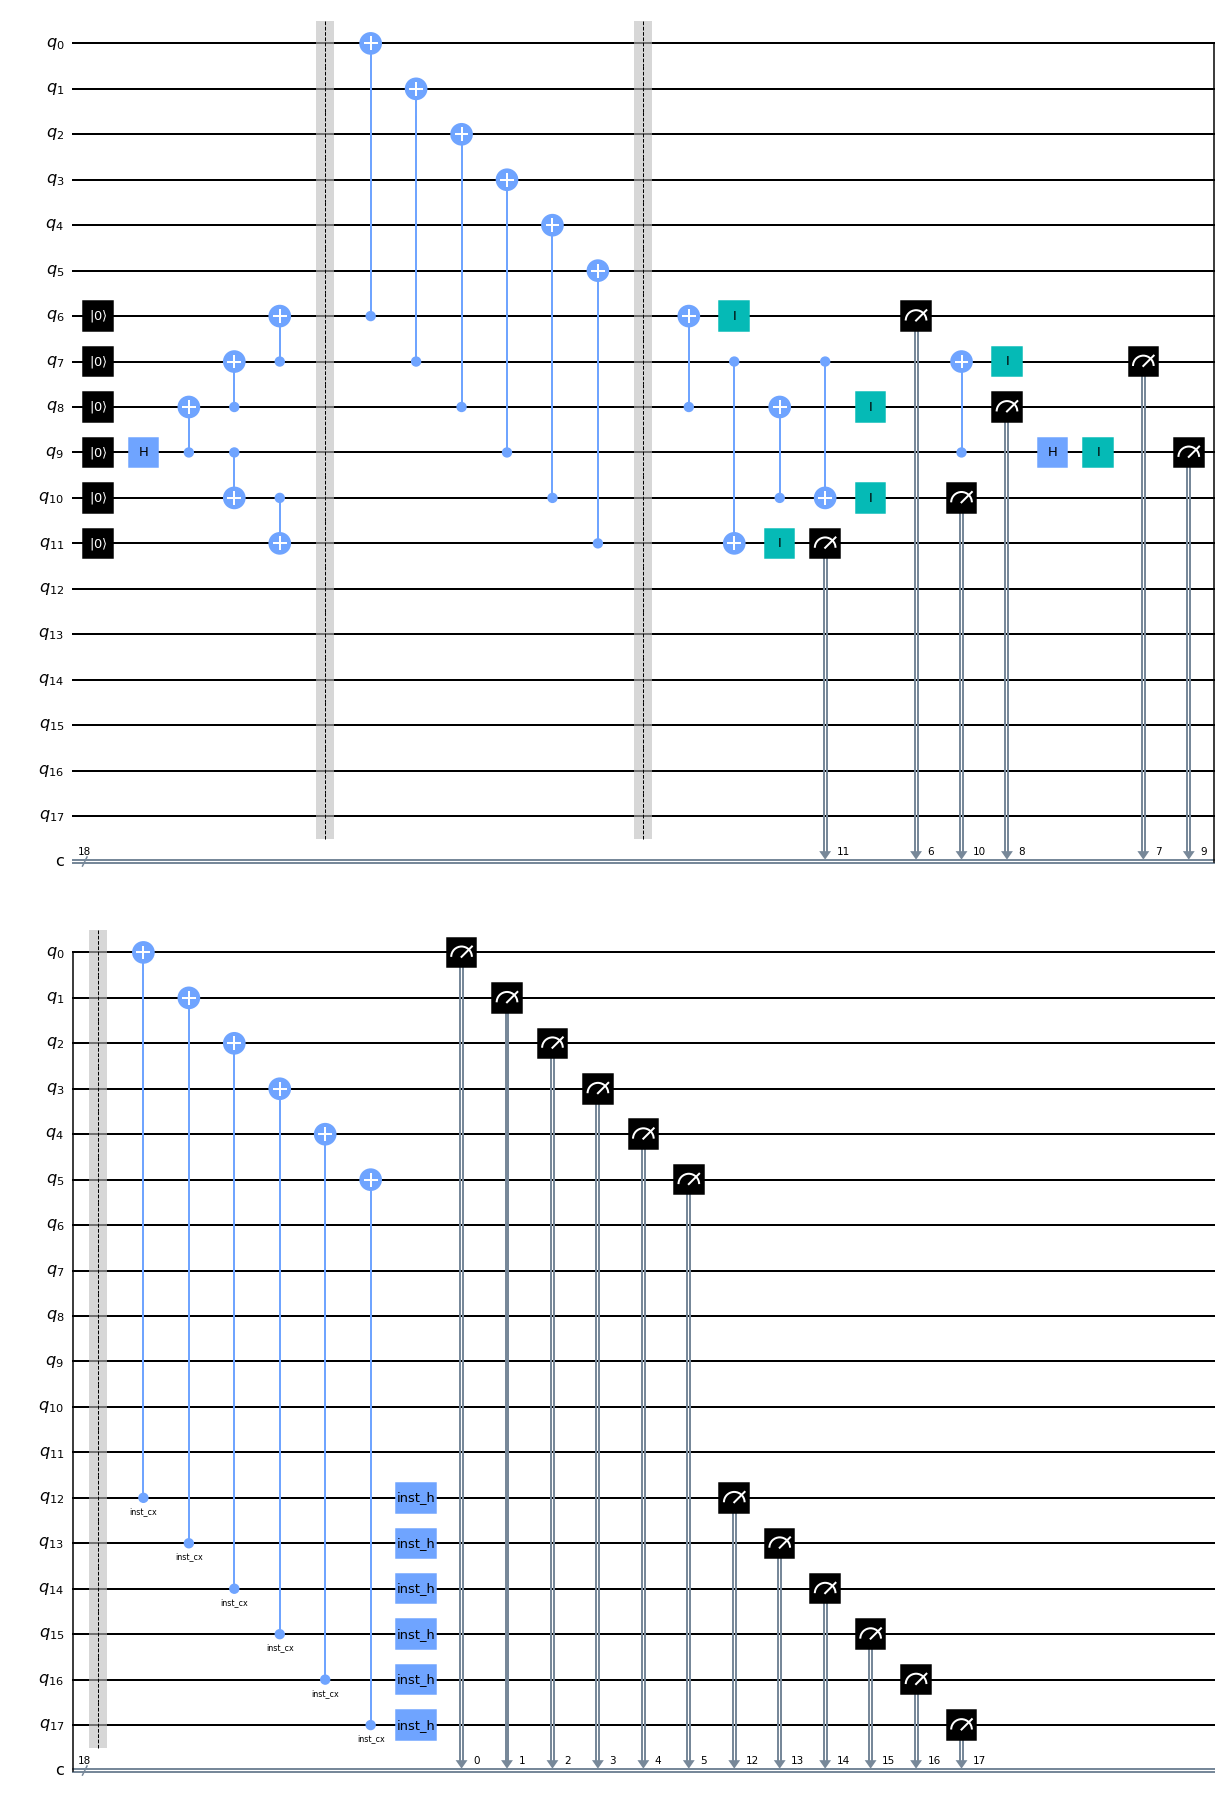

In [15]:
qc = QuantumCircuit(18, 18)
# Prepare aux. system
qc.reset(6)
qc.reset(7)
qc.reset(8)
qc.reset(9)
qc.reset(10)
qc.reset(11)
qc.h(9)
qc.cx(9, 8)
qc.cx(8, 7)
qc.cx(7, 6)
qc.cx(9, 10)
qc.cx(10, 11)
qc.barrier()
# Interact with code block
qc.cx(6, 0)
qc.cx(7, 1)
qc.cx(8, 2)
qc.cx(9, 3)
qc.cx(10, 4)
qc.cx(11, 5)
qc.barrier()
# Measure aux. system
qc.cx(8, 6)
qc.cx(7, 11)
qc.cx(10, 8)
qc.cx(7, 10)
qc.cx(9, 7)
qc.h(9)
qc.id(6)
qc.id(7)
qc.id(8)
qc.id(9)
qc.id(10)
qc.id(11)
qc.measure(6, 6)
qc.measure(7, 7)
qc.measure(8, 8)
qc.measure(9, 9)
qc.measure(10, 10)
qc.measure(11, 11)
# Instrument the code block to detect bit and phase flips
qc.barrier()
for i in range(6):
    qc.cx(i + 12, i, label="inst_cx")
    qc.append(HGate(label="inst_h"), [qc.qubits[i+12]])
for i in range(6):
    qc.measure(i, i)
    qc.measure(i + 12, i + 12)
qc.draw(output='mpl')

Let's build up a list of events first.

In [16]:
fe = FaultEnumerator(qc, 1, "propagator", model=model, sim_seed=0)
result1 = list(fe.generate_blocks())[0]

We will store X errors on the data in a dictionary with flag outcomes as keys.

In [17]:
data_by_flag_1 = {}
for record in result1:
    data = record[3][0:6]
    if sum(data) > 3:
        data = [(x+1)%2 for x in data]
    data = tuple(data)
    flags = record[3][6:9]
    flags.append(record[3][10])
    flags.append(record[3][11])
    flags = tuple(flags)
    data_by_flag_1.setdefault(flags, set([]))
    data_by_flag_1[flags].add(data)

In [18]:
fe = FaultEnumerator(qc, 2, "propagator", model=model, sim_seed=0)
result2 = []
for x in fe.generate_blocks():
    result2.extend(x)

In [19]:
data_by_flag_2 = {}
for record in result2:
    data = record[3][0:6]
    if sum(data) > 3:
        data = [(x+1)%2 for x in data]
    data = tuple(data)
    flags = record[3][6:9]
    flags.append(record[3][10])
    flags.append(record[3][11])
    flags = tuple(flags)
    data_by_flag_2.setdefault(flags, set([]))
    data_by_flag_2[flags].add(data)

Now let's search for a candidate set of X corrections to the data such that 1 fault leaves no more than 1 residual X error and 2 faults leave no more than 2 residual X errors.

In [21]:
# Apply a correction to a set of errors and test for weights above a cutoff
def test_correction(err_iterable, correction, cutoff):
    for y in err_iterable:
        wt = sum([(u + v) % 2 for u, v in zip(y, correction)])
        if wt > 3:
            wt = 6 - wt
        if wt > cutoff:
            return False
    return True

In [30]:
lookup_table = {}  # store feasible corrections in a lookup table

# Iterate over all flag outcomes
for x in range(2**5):
    flag = "{0:05b}".format(x)
    tup = tuple(map(int, list(flag)))
    err1 = list(data_by_flag_1.get(tup, set()))
    err2 = list(data_by_flag_2.get(tup, set()))
    # Iterate over all possible corrections for this flag outcome
    for corrint in range(2**6):
        correction = tuple([int((2**i & corrint)>0) for i in range(6)])
        if sum(correction) > 3:
            correction = [(u+1) % 2 for u in correction]
        if test_correction(err1, correction, 1) and test_correction(err2, correction, 2):
            lookup_table[tup] = tuple(correction)
            break
        if corrint == 2**6 - 1:
            print("FAIL")

In [31]:
reverse_table = {}
for flag, correction in lookup_table.items():
    flagstr = "".join(map(str, flag))
    corrstr = "".join(map(str, correction))
    reverse_table.setdefault(corrstr, [])
    reverse_table[corrstr].append(flagstr)

# Print markdown for the lookup table
for correction, flaglist in reverse_table.items():
    if correction != "000000":
        print("|" + ",".join(flaglist) + "|" + correction + "|")

|00100,11010,11011,11101|100000|
|00101,00111|000011|
|01001,01110|000100|
|01011,11111|010000|
|01100,01101|000010|
|01111,10011|110000|
|10111|011000|


#### Lookup table of corrections for each flag outcome

Corrections are written modulo {000000,111111}.

|flag|correction|
|----|----|
|00100,11010,11011,11101|100000|
|00101,00111|000011|
|01001,01110|000100|
|01011,11111|010000|
|01100,01101|000010|
|01111,10011|110000|
|10111|011000|

### Testing the deflagging protocol

In [33]:
def deflag2(result, lookup_table):
    processed_result = deepcopy(result)
    for record in processed_result:
        flags = record[3][6:9]
        flags.extend(record[3][10:12])
        for flag_val, correction in lookup_table.items():
            if tuple(flags) == flag_val:
                for i in range(6):
                    record[3][i] = (record[3][i] + correction[i]) % 2
    return processed_result

In [36]:
weights = {}
for record in deflag2(result1, lookup_table):
    datax = record[3][0:6]
    dataz = record[3][12:18]
    if sum(datax) > 3:
        datax = [(x + 1) % 2 for x in datax]
    num_errors = sum([int((x + y) > 0) for x, y in zip(datax, dataz)])
    weights.setdefault(num_errors, set([]))
    weights[num_errors].add((sum(datax), sum(dataz)))
    if num_errors > 1:
        print("FAILED!")
weights

{1: {(0, 1), (1, 0), (1, 1)}, 0: {(0, 0)}}

In [37]:
weights = {}
for record in deflag2(result2, lookup_table):
    datax = record[3][0:6]
    dataz = record[3][12:18]
    if sum(datax) > 3:
        datax = [(x + 1) % 2 for x in datax]
    num_errors = sum([int((x + y) > 0) for x, y in zip(datax, dataz)])
    weights.setdefault(num_errors, set([]))
    weights[num_errors].add((sum(datax), sum(dataz)))
    if num_errors > 2:
        print("FAILED!")
weights

{0: {(0, 0)},
 1: {(0, 1), (1, 0), (1, 1)},
 2: {(0, 2), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)}}

Great! If this weight-6 syndrome measurement circuit is 1- or 2-good (with ideal input), then its output will pass a 1- or 2-filter, respectively.

How about 3 faults? Since we can reduce the error on the data to at most 3 X errors, we expect the circuit to be 3-fault-tolerant *in the CSS sense*. Can we remove the qualifier?

In [38]:
fe = FaultEnumerator(qc, 3, "propagator", model=model, sim_seed=0)
result3 = []
for x in fe.generate_blocks():
    result3.extend(x)

In [40]:
weights = {}
failed = False
for record in deflag2(result3, lookup_table):
    datax = record[3][0:6]
    dataz = record[3][12:18]
    if sum(datax) > 3:
        datax = [(x + 1) % 2 for x in datax]
    num_errors = sum([int((x + y) > 0) for x, y in zip(datax, dataz)])
    weights.setdefault(num_errors, set([]))
    weights[num_errors].add((sum(datax), sum(dataz)))
    if num_errors > 3:
        failed = True
print("failed? ", failed)
weights

failed?  True


{1: {(0, 1), (1, 0), (1, 1)},
 0: {(0, 0)},
 2: {(0, 2), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)},
 3: {(0, 3),
  (1, 2),
  (1, 3),
  (2, 1),
  (2, 2),
  (2, 3),
  (3, 0),
  (3, 1),
  (3, 2),
  (3, 3)},
 4: {(1, 3), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)},
 5: {(2, 3), (3, 2), (3, 3)}}

Nope. The circuit is not 3-fault-tolerant in the strictest sense, so we need to be careful if we plan to measure checks for codes with minimum distance greater than 5.

Can you find a less expensive and/or "more" fault-tolerant circuit?